# What my partner would like from my Spotify music choice? 
## Music Analyzer based on Spotify Streaming Histories and Song Features

Back in early July, Spotify introduced a new Premium Duo service. Apart from a (slightly) cheaper monthly average fee for each person with the joint subscription, the two users also have access to a 'Duo Mix' playlist, which supposedly is  updated regularly based on what both users like. So far, my partner absolutely hated most the 'new' songs shown on this new playlist (the 'new' songs would be my contribution based on what I usually listened to). This got me wondering if there are songs I like that may also be favoured by my partner based on his listening habit.  

<br> <div>
<img src="img/spotify_duo.jpg" width="300" align="left"/>
</div>

The project here analyzes the streaming histories of my partner and me in the last 12 months, in relation to some metrics of song characteristics that are available from a large collated 'song attributes' database. The database contains 160,000+ songs released in the years between 1921 and early 2020. 

**The objective** of this project is to build a classifier that can be used to predict what new songs a person may like (and not like) based on their listening histories. 

### About the Music Data

This project uses two sources of data: i) **Spotify audio/track features** ("song_attributes.csv") & ii) **personal streaming history on Spotify** ("xx_StreamingHist.csv").

**'song_attributes.csv'** is a dataset available on Kaggle (https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks; I used the specific file named 'data.csv') (Thanks Yamaç Eren Ay for sharing it publicly). The file contains 19 columns including various song features such as acousticness, danceability, and liveness etc, collected through Spotify Web API. (For more details of these features, check this link: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) There are 169,909 rows/entries, with each row representing an individual song. In a separate notebook ([check here](EDA_Song_Attributes_Exploration.ipynb)), I did more exploration on this 'song attributes' data set, for example examining how songs vary in these features across years.

The two **'xx_StreamingHist.csv'** contains personal streaming data from partner0 and partner1 (for example, from me and my partner) requested via the Privacy Settings section of the individual Spotify's account pages (https://support.spotify.com/us/article/data-rights-and-privacy-settings/). The data were provided in the json format. There are four columns in the data-file (artistName, trackName, endTime, msPlayed). Partner0's file has 15344 entries/rows and partner1's has 11424 entries.

As partner0 has slightly more data (i.e. a long list of listening), partner0's data is used for training the models. The models trained (based on partner0's streaming history) will then be fitted on partner1's data, i.e. to predict what songs from partner1's list that partner0 may like. 

### Definition of 'Favourite' (vs 'not Favourite') song classes

**'Favourite' (1)** and **'not favourite' (0)** songs are defined by the number of listens in the past 12 months. From an exploratory analysis (see histogram below), I found that with an overpowering majority of songs Partner0 only listened to them for less than 5 times last year, and this person quite seldom listened to a song more than 5 times. This is a clear cut-off. 

Check the section **'What makes a favourite song'** below for more details.

### Predictive Modelling

I will mainly compare the performance of 3 classification models here:   
> <b>Nu Support Vector Classifier</b>   
  <b>Decision Tree</b>    
  <b>Random Forest</b>     
  (# Logistic Regression as well for comparison purpose)
    
Before narrowing down the search for further hyperparameter tuning with these models, I'd also tested a number of other classifiers (e.g. Gaussian Processes, Gradient Boosting, Multilayer Perceptron), the performances of which were not as great. The [scripts](init_model_selection.py) and [outputs](init_outputs.txt) of those initial exploratory attempts are stored in the same repo with this notebook.

### Evaluation metrics - F1 score

When dealing with datasets with a high class imbalance like our case here (there are much fewer 'favourite' songs based on partner0's listening habit), accuracy may not be a reliable measure. The reason is that a high accuracy can be solely/largely contributed by a large number of correctly predicted negatives (i.e. True Negatives) while the positive class could be poorly predicted. In scenarios with heavily imbalanced data, we care equally about precision and recall, and F1 score would be a more preferred evaluation metric.

Precision is a measure of the correctly identified positive cases from all the predicted positive cases. It is useful when the costs of False Positives is high. Recall measures the ratio of the correctly identified positive cases to all the actual positive cases. It is important when the cost of False Negatives is high.

Then, F1 score is a harmonic mean of Precision and Recall, thus giving more attention to the incorrectly classified cases in general. 

### Highlights of Results

A trained model using a Random Forest Classifier was able to predict unseen test data with a F1 score of 77%, which would be used as the final algorithm for music recommendation to predict what songs partner0 may like in an entirely separate partner1's songlist.   

In comparison, Decision Tree Classifier acquired a score of 66% and Nu Support Vector Classifier a very low score of 53%

### Reference/Acknowledgement

There are different song recommendation algorithms available out there and the one created by [isaclee](https://github.com/isacmlee/song-recommender) that I came across  is really well thought and easily extendable. Do check out check out isaclee's repo. My analysis has extended on his work. I did more [general data exploration](EDA_Song_Attributes_Exploration.ipynb) and trained a wider range of models as [an initial exploratory attempt](init_outputs.txt) at the beginning (before filtering out models with very low performance). 

## ** Codes start here **

### Environment / File Preparation

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Read in personal Streaming History data
def readCSV(data):
    return pd.read_csv(data)
    
SH0_df = readCSV("partner0_StreamingHist.csv") #data from partner0 that will be used for building/training the ML models
SH1_df = readCSV("partner1_StreamingHist.csv") #data from partner1 that will be used in final predictions

# Read in Song Attributes data
df_attr = readCSV("song_attributes.csv")

SH0_df.shape, SH1_df.shape, df_attr.shape

((15344, 5), (11424, 5), (169909, 19))

In [3]:
# Some data cleaning 
# remove some special characters ([,],',") in the 'artists' column in the 'song attributes' dataset
df_attr['artists'] = df_attr['artists'].replace({r'\[|\]|\'|\"':''}, regex=True)
df_attr = df_attr.rename(columns={'name':'track'})
SH0_df = SH0_df.rename(columns={'artistName':'artists', 'trackName':'track'}).drop('Unnamed: 0', axis=1)
SH1_df = SH1_df.rename(columns={'artistName':'artists', 'trackName':'track'}).drop('Unnamed: 0', axis=1)


In [4]:
# Shortlist only songs from SH0_df that also have 'song attributes' information
sl_df0 = pd.merge(SH0_df, df_attr[['track', 'artists']], how='inner', on=['track', 'artists'])

sl_df0.head(5)

,endTime,artists,track,msPlayed
0,30/07/2019 13:40,The Blue Nile,Tinseltown in the Rain,306831.0
1,30/07/2019 14:18,David Gray,Babylon,265666.0
2,10/12/2019 07:02,David Gray,Babylon,265666.0
3,01/01/2020 21:54,David Gray,Babylon,1300.0
4,20/01/2020 09:15,David Gray,Babylon,265666.0


### Data Exploration

#### What makes a favourite song - why set the cut-off at 5 listens? 

From the histogram below, there is a sudden drop in song frequencies around 5 (listens). It seems that with the majority of songs partner0 would not listen to them for more than 5 times. Using 5 as the cut-off also likely removes songs that partner0 might come across by chance on radios or songs that were randomly suggested by Spotify. 

Using this cutoff, we label songs with more than 5 listens last year as favourites (class 1) and songs with few listens as not favourites (class 0). 

Text(0.5, 1.0, 'Frequency of no. of listens')

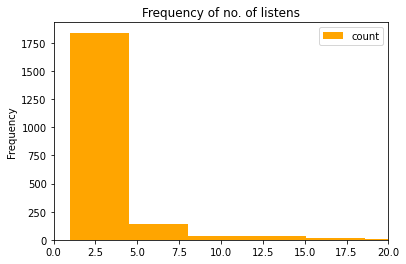

In [5]:
ax=sl_df0.groupby(['track', 'artists'])['track'].count().to_frame('count').reset_index().plot(kind='hist', bins=40, color="orange")
ax.set_xlim(0,20)
ax.set_title("Frequency of no. of listens")

We may also use the total of 'msPlayed' (for each song) as a criterion to define 'favourite' and 'non-favourite' songs. However, songs differ in duration. To take into accounts this confound, we would have to take action, for example, to standardise the 'msPlayed' for each song by dividing it with the actual duration of the song. It is very likely the results after this adjustment would be very similar or comparable to using the number of listens at the end. 

In [12]:
# Count the number of occurences of each song in the shortlisted data
df0_freq = sl_df0.groupby(['track', 'artists'])['track'].count().to_frame('count').reset_index()
df0_freq.head(10)

,track,artists,count
0,"""45""",The Gaslight Anthem,1
1,"""Heroes"" - Live; 2005 Remaster",David Bowie,1
2,'Helden' - German Version 1989 Remix; 2002 Rem...,David Bowie,12
3,(Everybody Wanna Get Rich) Rite Away,Dr. John,1
4,(Feels Like) Heaven,Fiction Factory,2
5,(I Can't Get No) Satisfaction - Mono Version,The Rolling Stones,4
6,"(Si, Si) Je Suis Un Rock Star",Bill Wyman,2
7,(Sittin' On) The Dock Of The Bay - Remastered ...,Glen Campbell,4
8,(You Make Me Feel Like) A Natural Woman,Aretha Franklin,2
9,(Your Love Keeps Lifting Me) Higher & Higher,Jackie Wilson,2


In [13]:
# Some examples of songs that have 5 or more occurrences/listens in the previous year
df0_freq[df0_freq['count'] >= 5].tail(5)

,track,artists,count
2026,You Can Call Me Al,Paul Simon,8
2028,You Can't Hurry Love - 2016 Remaster,Phil Collins,46
2042,You Make My Dreams (Come True),Daryl Hall & John Oates,10
2072,Your Song,Elton John,6
2079,bad guy,Billie Eilish,41


In [14]:
# Save songs with 5 or more listens as 1 ('favourite')
df0_freq['favourite'] = np.where(df0_freq['count'] >= 5, 1, 0)
df0_freq = df0_freq.drop('count', axis=1)

In [15]:
# merging 'favourite' column into the 'song attributes' datafile (this returns only songs that parter0 had listened to in the previous year)
df0 = pd.merge(df0_freq, df_attr, how='inner', on=['track', 'artists'])
df0.drop(columns = ['id', 'key', 'mode', 'release_date', "explicit", "year"], inplace=True)
df0.head(5)


,track,artists,favourite,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence
0,"""45""",The Gaslight Anthem,0,0.000696,0.315,202493,0.970,0.00000,0.2770,-4.709,48,0.1020,178.068,0.423
1,"""Heroes"" - Live; 2005 Remaster",David Bowie,0,0.028800,0.489,374533,0.814,0.02100,0.8010,-7.705,30,0.0323,114.211,0.738
2,'Helden' - German Version 1989 Remix; 2002 Rem...,David Bowie,1,0.000085,0.444,220707,0.674,0.25400,0.1160,-7.791,49,0.0298,112.459,0.485
3,(Everybody Wanna Get Rich) Rite Away,Dr. John,0,0.518000,0.746,163933,0.916,0.06860,0.0785,-10.061,53,0.0772,99.926,0.971
4,(Feels Like) Heaven,Fiction Factory,0,0.198000,0.542,214047,0.820,0.00172,0.0497,-10.982,45,0.0512,116.666,0.762


### Exploration of Song Feature data
(before diving into model building)

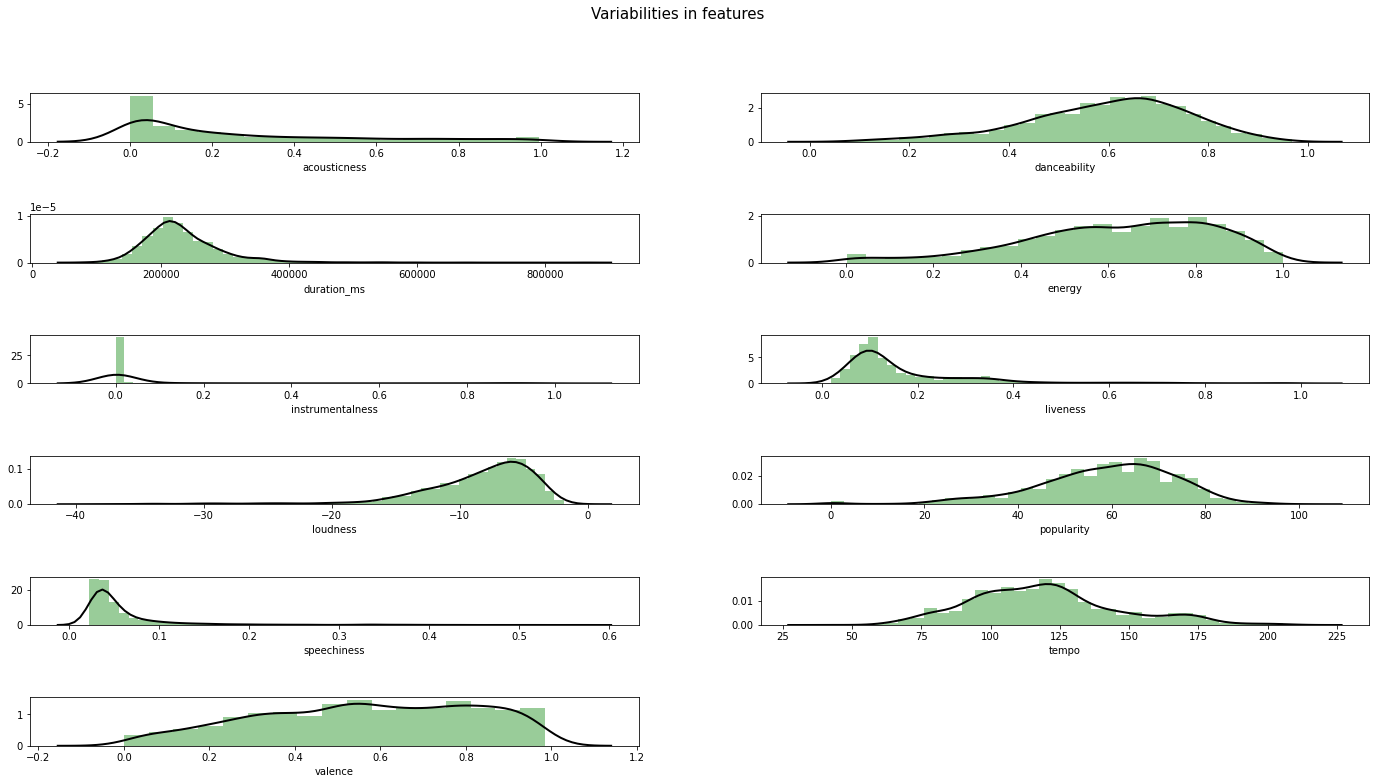

In [16]:
## plot histograms for continuous variables

def dist_plot(feature, i, kde_color, hist_color):
    '''
    this function plots a histogram using seaborns.displot
    feature: column name of an attribute
    i: which subplot to overlay on
    kde_color: colour of the kernel desnsity estimation curve
    hist_color: colour of the histogram bars
    '''
    sns.distplot(df0[feature], kde=True, ax=ax[i//2, i%2],
                kde_kws={"color": kde_color, "lw":2}, color = hist_color).set_xlabel(feature)


fig, ax = plt.subplots(6, 2, figsize=(24,12))

kde_color = "black"
hist_color = "g"

col2check = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "liveness", "loudness", 
             "popularity", "speechiness", "tempo", "valence"]


for i, column in enumerate(col2check):
    dist_plot(column, i, kde_color, hist_color) 

fig.suptitle('Variabilities in features', fontsize = 15)

# make the subplots not overlap with each other...
fig.subplots_adjust(hspace=1.5)

fig.delaxes(ax[5,1])



From the series of plots above, looks like Partner0's song list has a very small variability in the feature 'Instrumentalness' (check the descriptive stat summary table below as well). Instrumentalness may not be a very useful feature but in the current round of model building let's just keep it for the time being. 

In [17]:
df0[col2check].describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence
count,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000
mean,0.260327,0.598151,233332.185786,0.622921,0.073404,0.172302,-8.616876,58.820707,0.059868,119.488791,0.567462
std,0.285591,0.162886,61090.640191,0.218438,0.214385,0.145347,4.769407,14.823804,0.057209,26.882853,0.251753
min,0.000002,0.056900,77213.000000,0.001690,0.000000,0.019300,-38.480000,0.000000,0.022400,43.513000,0.000010
25%,0.031925,0.497000,195796.750000,0.484000,0.000000,0.088175,-10.642500,50.000000,0.032100,100.050250,0.369000
50%,0.140500,0.618000,223166.500000,0.652000,0.000034,0.116000,-7.502500,61.000000,0.040700,117.934000,0.576000
75%,0.422250,0.713000,260759.750000,0.797000,0.004395,0.206250,-5.434250,69.000000,0.060700,133.124250,0.782000
max,0.996000,0.968000,865000.000000,1.000000,0.996000,0.996000,-1.101000,100.000000,0.567000,210.164000,0.985000


The correlation matrix below shows that there isn't much linear association between any recorded song features and the 'favourite/not-favourite' classes. A model based on the linear relationship may not be very useful. 

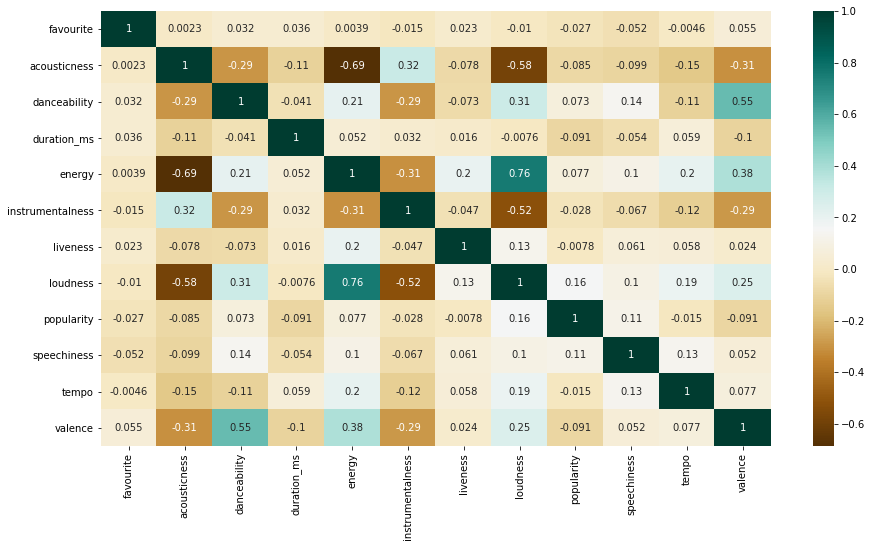

In [18]:
# Correlation matrix of Song Features
plt.figure(figsize=(15,8))
c = df0.drop(columns = ["track", "artists"]).corr()
corr = sns.heatmap(c, cmap="BrBG", annot=True)


### Model Selection (Cross-validation and Hyperparameter Tuning)

I will mainly compare the performance of 3 classification models here:

> <b>Nu Support Vector Classifier</b>   
  <b>Decision Tree</b>    
  <b>Random Forest</b>    
  (Logistic Regression for comparison purpose)

Before shortlisting these classification models for further hyperparameter tuning, I'd also tested a number of other models exploratively. The [scripts](init_model_selection.py) and [outputs](init_outputs.txt) of these exploratory attempts can be found in the same repo. 

In [19]:
# Importing required libraries

from imblearn.over_sampling import SMOTE

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, plot_confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import NuSVC


In [20]:
# Split Data into Train sets and Test sets
X_train, X_test, y_train, y_test = train_test_split(df0.drop(columns=["track", "artists", "favourite"]), df0["favourite"], test_size=.20, random_state=40)

#### Balancing Classes with SMOTE (Oversampling approach) on continuous variables

In [21]:
y_train.value_counts()

0    1847
1     370
Name: favourite, dtype: int64

The classes (1: 'favourite' vs 0: 'not-favourite') are quite imbalanced in our case. The models will predict most songs as the majority class (i.e., 0) if no adjustment is done, and this will affect the interpretation of model performance. There are some tactics we can use to potentially alleviate this problem.  

For more information, this is a good post on the issue of 'Imbalanced Classes in Machine Learning Dataset'. https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

Here, we are using the SMOTE oversampling approach to generate synthetic samples and as a result we wll have more (and different) data. SMOTE creates synthetic samples by randomly sampling the attributes from instances in the minority class (instead of creating copies). SMOTE stands for Synthetic Minority Over-sampling Technique. 

In [22]:
# Apply SMOTE
# again to prevent data leakage into Test set, it's important to split the data before applying SMOTE

X_trainS, y_trainS = SMOTE().fit_resample(X_train, y_train)
X_testS, y_testS = SMOTE().fit_resample(X_test, y_test)


# Also, many machine learning algorithms perform better when numerical input variables are scaled to a standard range.
# This is especially relevant for algorithms that fit a model using a weighted sum of inputs, such as linear regression, logistic regression,
# as well as algorithms that use distance measures like k-nearest neighbours.
# To prevent data leakage into Test set, transformation (rescaling) is first learnt and done with Train set before applying it onto the Test set

mmscaler = MinMaxScaler()



For each model below, cross-validation is used to see how well each model generalises and obtains a F1 score.

### Logistic Regression (for comparison)

As speculated according to the correlation matrix above, a model using an algorithm based on (generalised) linear relationships such as logistic regression isn't too useful in our case (The F1 scores for predicting train data and unseen test data are both very close to 50% - see below)

In [23]:
# Logistic Regression

lr = Pipeline(steps=[('mmscaler', mmscaler), ('classifier', LogisticRegression(max_iter=1000, random_state=13))])
lr_scores = cross_val_score(lr, X_trainS, y_trainS, cv=10, scoring="f1", n_jobs=-1, verbose=2)

print('All scores in CV for Train data: ', lr_scores, '\n', 
      'Mean F1 score for Train data: ', np.mean(lr_scores))

# Testing Logistic Regression model with the unseen Test set
lr.fit(X_trainS, y_trainS)
y_pred = lr.predict(X_testS)
print('F1 score for unseen Test data: ', f1_score(y_testS, y_pred))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


All scores in CV for Train data:  [0.54301075 0.49456522 0.50828729 0.55466667 0.5483871  0.54246575
 0.53781513 0.53908356 0.57217848 0.53296703] 
 Mean F1 score for Train data:  0.5373426974421899
F1 score for unseen Test data:  0.5517970401691332


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished


### Nu Support Vector Classifier

In [24]:
# Hyperparameter optimization of NuSVC classification

parameters = {
    'nu':[0.001, 0.005, 0.1, 0.25, 0.5],    #tested [0.9]
    'gamma': [20, 50, 100, 150],  #for rbf, test [1, 5, 10,]
    'probability': [True, False]
}

svcv = Pipeline(steps=[('mmscaler', mmscaler), ('CV', GridSearchCV(NuSVC(random_state=13), parameters, cv = 5, scoring="f1", n_jobs=-1, verbose=2))])

svcv.fit(X_trainS, y_trainS)
svcv.named_steps['CV'].best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished


{'gamma': 50, 'nu': 0.1, 'probability': True}

In [25]:
# Fine-tuned NuSVC Pipeline

nusvc = Pipeline(steps=[('mmscaler', mmscaler), ('classifier', NuSVC(random_state=13, gamma=50, nu=0.1, probability=True))])

nusvc_scores = cross_val_score(nusvc, X_trainS, y_trainS, cv=10, scoring="f1", n_jobs=-1, verbose=2)


print('All scores in CV for Train data: ', nusvc_scores, '\n', 
      'Mean F1 score for Train data: ', np.mean(nusvc_scores))

# Testing NuSVC model with the unseen Test set
nusvc.fit(X_trainS, y_trainS)
y_pred = nusvc.predict(X_testS)
print('F1 score for unseen Test data: ', f1_score(y_testS, y_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.7s finished


All scores in CV for Train data:  [0.87052342 0.88767123 0.90410959 0.8839779  0.86363636 0.90217391
 0.87640449 0.86592179 0.86908078 0.86350975] 
 Mean F1 score for Train data:  0.8787009226467528
F1 score for unseen Test data:  0.5288035450516987


### Decision Tree

In [26]:
# Hyperparameter optimization for Decision Tree Classifier
parameters = {
    'max_depth':[5, 10, 15, 20, 30, 50, 100],    #tested also 200, 500
}

dtc = Pipeline(steps=[('mmscaler', mmscaler), ('CV', GridSearchCV(DecisionTreeClassifier(random_state=13), parameters, cv = 5, scoring="f1"))])

dtc.fit(X_trainS, y_trainS)
dtc.named_steps['CV'].best_params_

{'max_depth': 50}

In [27]:
# Fine-tuned Decision Tree Pipeline

dt = Pipeline(steps=[('mmscaler', mmscaler), ('classifier', DecisionTreeClassifier(max_depth=50, random_state=13))])
dt_scores = cross_val_score(dt, X_trainS, y_trainS, cv=10, scoring="f1", n_jobs=-1, verbose=2)

print('All scores in CV for Train data: ', dt_scores, '\n', 
      'Mean F1 score for Train data: ', np.mean(dt_scores))

# Testing Decision Tree model with the unseen Test set
dt.fit(X_trainS, y_trainS)
y_pred = dt.predict(X_testS)
print('F1 score for unseen Test data: ', f1_score(y_testS, y_pred))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


All scores in CV for Train data:  [0.73130194 0.70718232 0.84155844 0.82506527 0.81725888 0.83769634
 0.796875   0.82474227 0.78772379 0.78481013] 
 Mean F1 score for Train data:  0.795421437332706
F1 score for unseen Test data:  0.6635514018691588


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished


### Random Forest

In [28]:
# Hyperparameter optimization of Random Forest Classifier
parameters = {
    'max_depth':[20, 30, 50, 100],  #tried [10, 15,20,]
    'n_estimators':[30, 100, 150, 200]  #tried also [15, 30, 35, 40, 50,]
}

rfc = Pipeline(steps=[('mmscaler', mmscaler), ('CV', GridSearchCV(RandomForestClassifier(random_state=13), parameters, cv = 5, scoring="f1"))])

rfc.fit(X_trainS, y_trainS)
rfc.named_steps['CV'].best_params_

{'max_depth': 30, 'n_estimators': 150}

In [39]:
# Fine-tuned Random Forest Pipeline

rf = Pipeline(steps=[('mmscaler', mmscaler), ('classifier', RandomForestClassifier(max_depth = 30, n_estimators = 150, random_state=13))])

rf_scores = cross_val_score(rf, X_trainS, y_trainS, cv=10, scoring="f1", n_jobs=-1, verbose=2)


print('All scores in CV for Train data: ', rf_scores, '\n', 
      'Mean F1 score for Train data: ', np.mean(rf_scores))

# Testing RandomForest model with the unseen Test set
rf.fit(X_trainS, y_trainS)
y_pred = rf.predict(X_testS)
print('F1 score for unseen Test data: ', f1_score(y_testS, y_pred))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.2s finished


All scores in CV for Train data:  [0.75801749 0.7696793  0.92307692 0.92266667 0.89922481 0.92388451
 0.93766938 0.91383812 0.90339426 0.93472585] 
 Mean F1 score for Train data:  0.8886177304620599
F1 score for unseen Test data:  0.7749699157641396


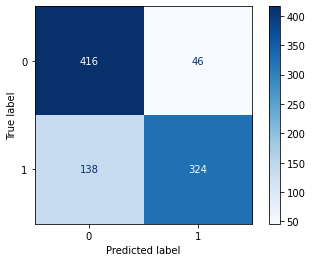

In [30]:
plot_confusion_matrix(rf, X_testS, y_testS, cmap="Blues")

Comparing different classification models, **Random Forest Classifier** was able to predict unseen test data with a F1 score of 77%, which would be used next in the final algorithm for music recommendation to predict what songs partner0 may like in an entirely separate partner1's songlist. 

## Predicting Songs from Partner1's list 
#### Recommending songs from Partner1's list that Partner0 may like

In [31]:
df1_freq = SH1_df.groupby(['track', 'artists'])['track'].count().to_frame('count').reset_index()

df_attr_uniq = df_attr.groupby(['track', 'artists']).mean().reset_index()


In [32]:
df1 = pd.merge(df1_freq, df_attr_uniq, how='inner', on=['track', 'artists'])
df1.drop('count', axis=1, inplace=True)
df1_X = df1.drop(['track', 'artists', 'key', 'mode', "explicit", "year"], axis=1)   #['id' 'release_date']

In [34]:
df1_X_scaled = mmscaler.transform(df1_X)

In [35]:
prediction = rf.predict(df1_X_scaled)

In [36]:
pred_df = df1[["track", "artists"]]
pred_df['prediction'] = prediction 


C:\Users\DrJKLau\anaconda3\envs\opencvenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
pred_df[pred_df["prediction"] ==1].head(5)

,track,artists,prediction
56,Bad,Lennon Stella,1
57,Bad Bad News,Leon Bridges,1
283,Harleys In Hawaii,Katy Perry,1
607,Say So,Doja Cat,1
661,Spinning Around,Kylie Minogue,1


In [ ]:
# Saving song list 
pred_df.to_csv("recommended_songlist.csv")

### As the next step, I am going to learn to automate the creation of a playlist using a Python script

### Try it out yourself as well!